# Exercise 1: Digit Classification with CNNs and DNNs
The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a database of hand-written digits matched with their actual value that has been exceedingly well used by the machine learning community. It is large and easily describable, which makes it a great example for learning to use convolutional neural networks.

This exercise draws extensively from [Keras tutorials](https://github.com/keras-team/keras/blob/master/examples).

This notebook contains many sections that are filled out for you and many that you will need to fill out to complete the exercise (marked in <font color='red'>RED</font>). You are finished when "Restarting and Run All Cells" executes the entire notebook without producing any errors. Do not remove assert statements.

If you get stuck, the correct code is in the cell below. Highlight the text to see it. Example: <font color='white'>print('Hello!')</font>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from tensorflow.keras import optimizers as opt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow import keras
from time import perf_counter
from math import isclose
import tensorflow as tf

import pandas as pd
import numpy as np
import warnings
np.random.seed(1)

## Load Data
The MNIST data is easily accessible from Keras and needs a little bit of preprocessing before it is useful.

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'Input data shape: {x_train.shape}')
print(f'Output data shape: {y_train.shape}')

Input data shape: (60000, 28, 28)
Output data shape: (60000,)


The data is returned as 60000 28x28 images.
Depending on the backend for Keras, we need to turn these into either 28x28x1 or 1x28x28 images.

In [3]:
img_rows, img_cols = 28, 28

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
print(f'New data shape: {input_shape}')

New data shape: (28, 28, 1)


The data are also integer values between 0 and 255. We need them as single-precision floating point numbers.

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

The classes are integers between 0 and 9. 
As we are treating digits as simple categories and not considering the ordering between them, we need to one-hot encode the data.
(Recall doing this in the last exercise for the categorical input variables)

In [7]:
num_classes = 10

In [8]:
print(f'Output for entry 0: {y_train[0]}')

Output for entry 0: 5


In [9]:
y_train = keras.utils.to_categorical(y_train, num_classes)

In [10]:
print(f'New output for entry 0: {y_train[0]}')

New output for entry 0: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [11]:
print(f'New output data shape: {y_train.shape}')

New output data shape: (60000, 10)


Alright, we are now ready to go

## Quick Tutorial: Classification Models and Keras
All of our previous examples have used regression models.
So, some brief lessons on classification.

#### Scoring Classification Models
There are [many ways to rate the quality of classification](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics), each with their own benefits.

For example, the [False Positive Rate (FPR)](https://en.wikipedia.org/wiki/False_positive_rate) scores how often your model yields an incorrect prediction.
FPR is good for metrics where the cost of reacting to an incorrect positive is high, but would be a poor choice when missing a detection is bad (e.g., fast screening for disease).

Our digit classification challenge is simple. We just want to get as many digits correct as possible.
Getting more "0"s correct is just as important as getting any other digit.
So, for that reason, we will use accuracy as a metric.

In [12]:
accuracy_score([0, 1, 0], [0, 1, 1])

0.6666666666666666

Accuracy is great for humans to understand the quality of a model but has a big issue if it were used as a loss function: discontinuous derivates.

Classification models produce probabilities of an entry (e.g., an image) being in a certain category (e.g., a certain digit) and accuracy scores do not use them well.
Small changes in predictions for the probabilities of each entry can lead to step changes in the accuracy.
Step changes lead to infinite gradients, which causes problems with gradient decent optimization.

So, instead, we use "log-loss" or "categorical cross entry." 
Log-loss has smooth derivates for all changes in probability, which is good for neural network optimization.
It also has a nice trait that predictions that are not just correct but more confidently-correct are given better (lower) scores.
Ther are other classification quality metrics that have these properties, but log-loss is what we will use today.

In [13]:
log_loss([0], [[0.6, 0.4]], labels=[0, 1]) > log_loss([0], [[0.7, 0.3]], labels=[0, 1])

True

#### Classification Layers and Keras
As you will see, special activation functions are needed for performing classification in Keras.

- `softmax` is a good choice for multi-class (i.e., more than 2 classes) classification problem. 
  It takes a vector of real numbers in and returns them in the range [0, 1] with a sum of 1, which looks like a probability distribution.
- `sigmoid` is a good choice for binary classification (only 2 classes) as, like `softmax`, it produces a number on [0, 1]. But, it only takes a single number as input, which makes it simpler than `softmax` to evaluate.

Illustrating `softmax`

In [14]:
model = Sequential([layers.Dense(10, activation='softmax', input_shape=(2,))])

In [15]:
output = model.predict(np.array([[-1, 2]]))  # Not trained, so the outputs are meaningless

In [16]:
print('Note that all numebrs are between 0 and 1:', output)

Note that all numebrs are between 0 and 1: [[0.01634549 0.25011343 0.07079231 0.01141161 0.2034941  0.12232955
  0.19988851 0.04452909 0.06790058 0.01319528]]


In [17]:
print('And they have a sum of 1 (or close to it): ', output.sum())

And they have a sum of 1 (or close to it):  1.0


## Part 1: Train a Fully Connected Neural Network
We will train a simple, fully connected neural network (FCNN) as a benchmark using the Keras `Sequential` model.

The [`Sequential` model](https://keras.io/getting-started/sequential-model-guide/) is designed for simple neural networks where the inputs one layer feed in to the outputs of the next.
Our FCNN will start with a [Flatten](https://keras.io/layers/core/#flatten) layer to shape the data from a Nx28x28x1 array to a Nx784 array.
Then, we will use 20 fully-connected (dense) layers to form a neural network.
The network ends with a `softmax` layer with 10 outputs.

In [18]:
model = Sequential()
model.add(layers.Flatten(input_shape=(28, 28, 1)))  # Telling Keras what size image to expect

In [19]:
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


We now assign the model a loss function (categorical cross-entropy, which is equivalent to the log-loss described above) and select an optimizer to train it

In [21]:
model.compile('rmsprop', 'categorical_crossentropy', metrics=['accuracy'])

Here, we fit the model with enough epochs for it to converge and a reasonable batch size. 
The `EarlyStopping` callbacks checks if the model has not improved for a certain number of epochs and, if so, rolls back to the best network to prevent overfitting.

In [22]:
model.fit(x_train, y_train, batch_size=64, epochs=512, validation_split=0.1,
          callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Train on 54000 samples, validate on 6000 samples
Epoch 1/512
54000/54000 [==============================] - 9s 173us/sample - loss: 0.2121 - accuracy: 0.9352 - val_loss: 0.1311 - val_accuracy: 0.9623
Epoch 2/512
54000/54000 [==============================] - 8s 154us/sample - loss: 0.0854 - accuracy: 0.9748 - val_loss: 0.0813 - val_accuracy: 0.9788
Epoch 3/512
54000/54000 [==============================] - 9s 158us/sample - loss: 0.0609 - accuracy: 0.9822 - val_loss: 0.1173 - val_accuracy: 0.9712
Epoch 4/512
54000/54000 [==============================] - 9s 158us/sample - loss: 0.0468 - accuracy: 0.9871 - val_loss: 0.0930 - val_accuracy: 0.9762
Epoch 5/512
54000/54000 [==============================] - 9s 171us/sample - loss: 0.0371 - accuracy: 0.9898 - val_loss: 0.1076 - val_accuracy: 0.9777
Epoch 6/512
54000/54000 [==============================] - 9s 160us/sample - loss: 0.0311 - accuracy: 0.9914 - val_loss: 0.1121 - val_accuracy: 0.9818
Epoch 7/512
54000/54000 [====================

In [23]:
dnn_accuracy = accuracy_score(model.predict_classes(x_test), y_test)
print(f'Accuracy on hold-out set: {dnn_accuracy * 100 : .2f}%')
assert dnn_accuracy > 0.975

Accuracy on hold-out set:  97.83%


## Part 2: Make a CNN
Now, we are going to build a simple Convolutional Neural Network to do the digit classification.

But first, a quick overview of Convolution Neural Networks. 

The "convolution" part of CNN references a type of layer were you apply a "filter" centered on each pixel to an image.
The filter is a function of the value of that pixel and surrounding filters.

For now, let's demonstrate with a "edge detection filter". Our goal will be to classify the following images based on whether they contain a vertical line.

In [24]:
dataset = np.zeros((3, 3, 3, 1))
dataset[0, :, 0] = 1
dataset[1, :, 2] = 1
dataset[2, 1, :] = 1

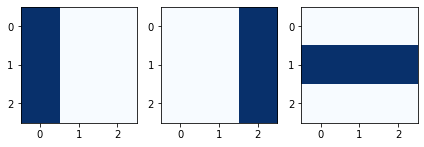

In [25]:
fig, axs = plt.subplots(1, 3)

for i, d in enumerate(dataset):
    axs[i].imshow(np.squeeze(d), cmap='Blues')
fig.tight_layout()

It is certainly possible to build an FCNN that will do this task, but we can make an even simpler model using a CNN.
First, to construct an "edge detection filter" in Keras

In [26]:
v_filter = np.array([[0, 1, 0], [0, 0, 0], [0, 1, 0]])

In [27]:
v_filter

array([[0, 1, 0],
       [0, 0, 0],
       [0, 1, 0]])

The filter in this case gives its maximum value if the pixels above and below a pixel are dark.

In [28]:
conv = Sequential([layers.Conv2D(filters=1, kernel_size=(3, 3), padding='same', use_bias=False, input_shape=(3, 3, 1))])  # Making a convolution layer for 2D images

In [29]:
conv.set_weights([v_filter[:, :, None, None]])

In [30]:
filtered = conv.predict(dataset)

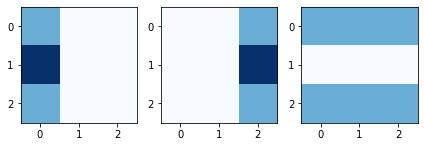

In [31]:
fig, axs = plt.subplots(1, 3)

for i, d in enumerate(filtered):
    axs[i].imshow(np.squeeze(d), cmap='Blues', vmax=2, vmin=0)
fig.tight_layout()

Note how the images with the vertical lines now have a different maximum pixel value than the one with the horizontal line. 
A "MaxPool" layer in Keras performs such an operation.

In [32]:
pool = Sequential([layers.MaxPool2D(pool_size=(3, 3))])

In [33]:
pooled = pool.predict(filtered)

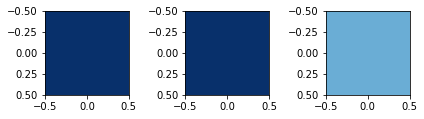

In [34]:
fig, axs = plt.subplots(1, 3)

for i, d in enumerate(pooled):
    axs[i].imshow(np.atleast_2d(np.squeeze(d)), cmap='Blues', vmax=2, vmin=0)
fig.tight_layout()

The classification is now easy: Dark blue (a value of 2) means vertical line.
The beauty of CNNs is that they can learn these filters for you automatically.

### <font color='red'>Your Turn: A CNN for MNIST</font>

The simple "convolution" plus "pooling" example above is indeed simpler than the common types of CNNs seen in practice.
We did not have a last layer that performs the actual classification, and used a "max pool" that reduced the image down to a single value.
Typically, we want multiple layers of convolutions to learn very complex filters and do not want to reduce an image down to a single pixel between each stage.
Further, adding a neural network to learn the actual classification at the end is common.

Your task is to train network from [Muhammad Rizwan's tutorial](https://engmrk.com/convolutional-neural-network-3/) with ReLU activation functions: 

<img width=50% src="https://engmrk.com/wp-content/uploads/2018/09/Image-Architecture-of-Convolutional-Neural-Network.png"/>

**HINT**: "Conv NxMxO" means O filters with shape NxM

**HINT**: There is a Flatten layer between the last Pooling layer and first FC (FC means Dense)

**HINT**: Don't forget `input_shape`!

<font color='white'>
model = Sequential([
    layers.Conv2D(32, (5, 5), input_shape=(img_cols, img_rows, 1)),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(64, (5, 5)),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(10, activation='softmax')
])
</font>

In [37]:
assert model.count_params() == 1111946

<font color='red'>Compile and train it</font>

Train on 54000 samples, validate on 6000 samples
Epoch 1/512
54000/54000 [==============================] - 42s 781us/sample - loss: 0.1283 - val_loss: 0.0565
Epoch 2/512
54000/54000 [==============================] - 42s 775us/sample - loss: 0.0457 - val_loss: 0.0487
Epoch 3/512
54000/54000 [==============================] - 40s 742us/sample - loss: 0.0301 - val_loss: 0.0777
Epoch 4/512
54000/54000 [==============================] - 40s 736us/sample - loss: 0.0213 - val_loss: 0.0575
Epoch 5/512
54000/54000 [==============================] - 41s 754us/sample - loss: 0.0196 - val_loss: 0.0604
Epoch 6/512
54000/54000 [==============================] - 40s 740us/sample - loss: 0.0138 - val_loss: 0.0671
Epoch 7/512
54000/54000 [==============================] - 39s 730us/sample - loss: 0.0125 - val_loss: 0.0734
Epoch 8/512
54000/54000 [==============================] - 42s 769us/sample - loss: 0.0098 - val_loss: 0.0668
Epoch 9/512
54000/54000 [==============================] - 39s 723us/sa

<font color='white'>
model.compile('rmsprop', 'categorical_crossentropy')
model.fit(x_train, y_train, batch_size=64, epochs=512, validation_split=0.1,
          callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])
</font>

Compute the score

In [39]:
cnn_accuracy = accuracy_score(model.predict_classes(x_test), y_test)
print(f'Accuracy on hold-out set: {cnn_accuracy * 100 : .2f}%')
assert cnn_accuracy > 0.985

Accuracy on hold-out set:  98.73%


The accuracy should be higher than your fully-connected nueral network!